# Assignment 2 | Image Classification, December 2021

- [Artificial Neural Networks and Deep Learning 2021 - Homework 2](https://codalab.lisn.upsaclay.fr/competitions/621)

## Three convolutioneers

- *Aleksandra Krajnovic*
- *Iva Milojkovic*
- *Mariusz Wiśniewski*

### Import libraries

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

plt.rc('font', size=16)
import warnings

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


### Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Utility function to create folders and callbacks for training

In [3]:
# Utility function to create folders and callbacks for training
from datetime import datetime


def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]

    # Model checkpoint
    # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, 'cp'),
        save_weights_only=False,
        save_best_only=False)
    callbacks.append(ckpt_callback)

    # Visualize Learning on Tensorboard
    # ---------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)

    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                                 profile_batch=0,
                                                 histogram_freq=1)
    callbacks.append(tb_callback)

    return callbacks

### Exploration Data Analysis (EDA)


Load the dataset

In [4]:
dataset = pd.read_csv('/kaggle/input/multivariatetimeseries/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


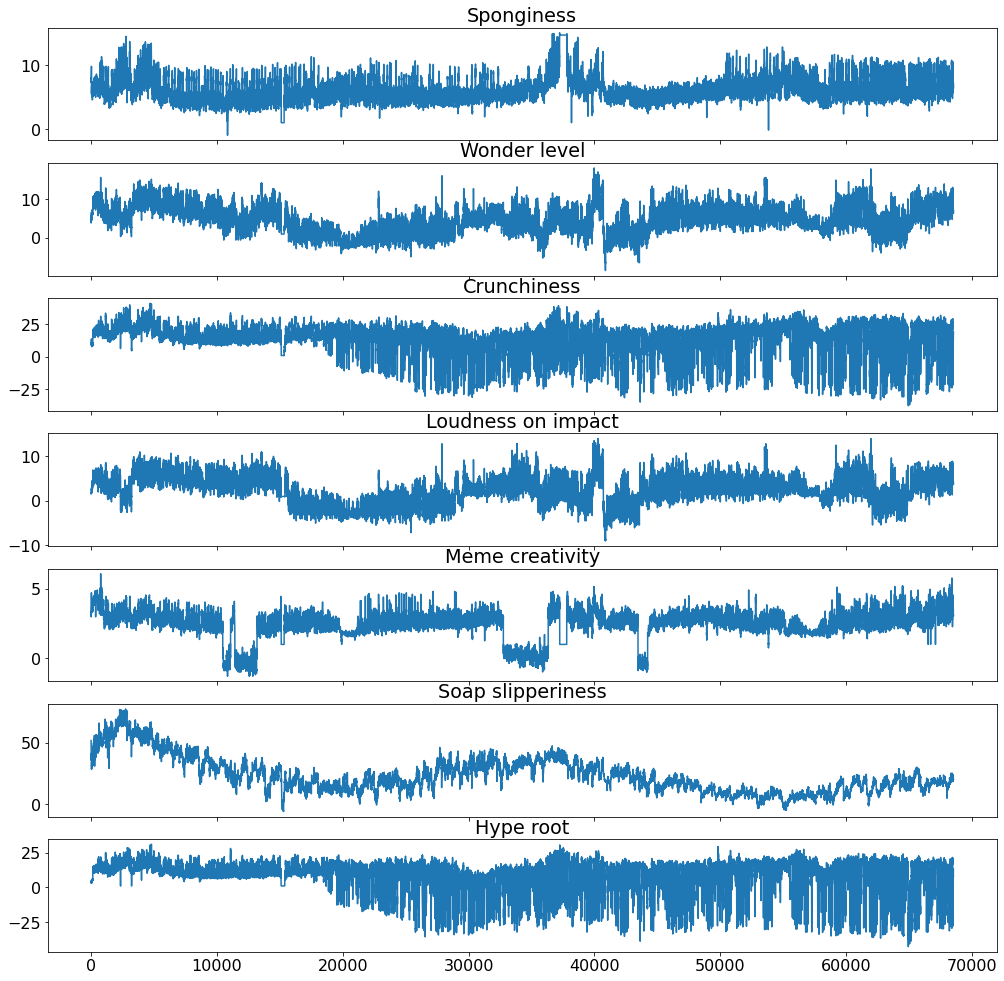

In [6]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17, 17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()


inspect_dataframe(dataset, dataset.columns)

Normalization

(68528, 7)
       Sponginess  Wonder level  Crunchiness  Loudness on impact  \
0         7.97698       4.33494    10.672820             1.76692   
1         8.07824       4.44616    10.561600             1.70716   
2         8.02844       4.22372    10.561600             1.64906   
3         8.02844       4.22372    10.561600             1.70716   
4         7.87572       4.44616    10.450380             1.70716   
...           ...           ...          ...                 ...   
68523     6.30868       6.33690    15.342401             4.24364   
68524     6.40994       6.55934    16.343380             3.77220   
68525     6.76352       7.00422    17.233140             3.94982   
68526     6.86478       6.67056    17.900460             3.94982   
68527     7.16856       7.11544    19.235099             4.12578   

       Meme creativity  Soap slipperiness  Hype root  
0              3.22440          51.681460    3.65434  
1              3.32566          51.563598    3.47672  
2      

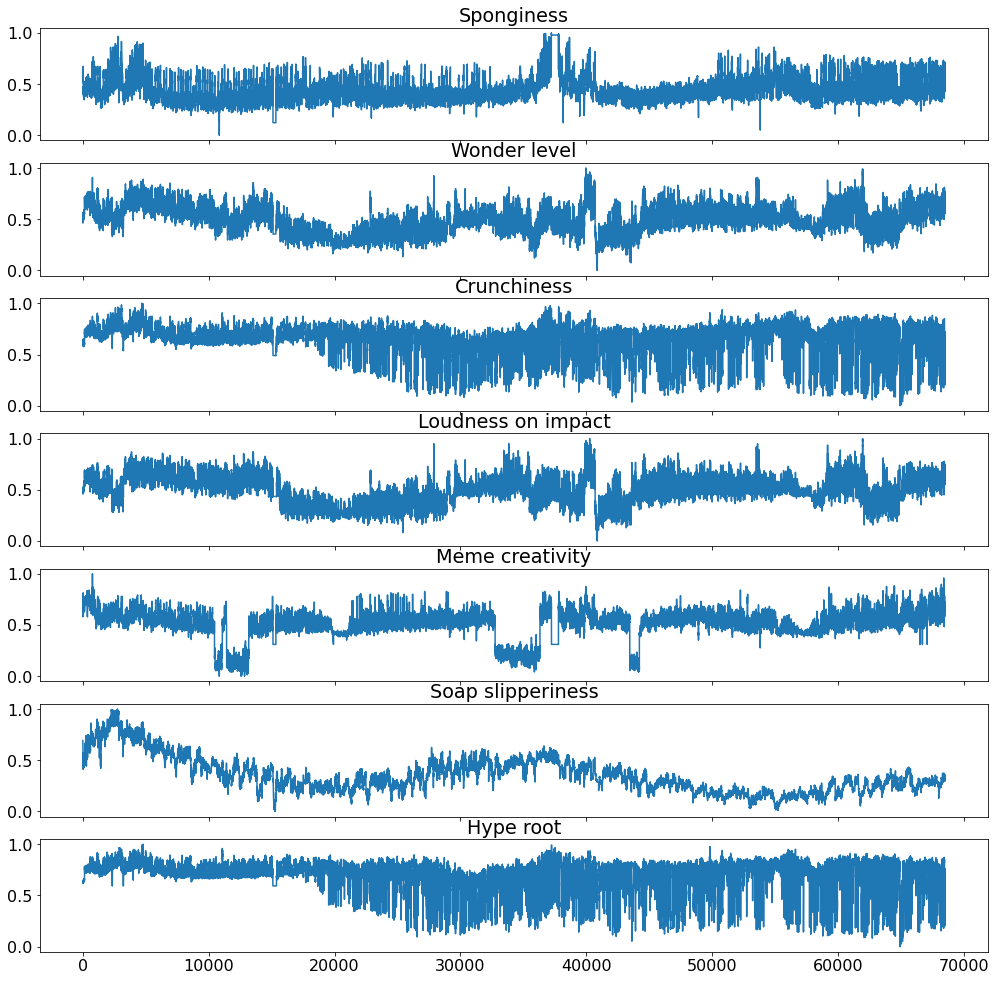

In [7]:
# Data normalization

X_train_raw = dataset
X_min = X_train_raw.min()
X_max = X_train_raw.max()
X_train_raw = (X_train_raw - X_min) / (X_max - X_min)

print(X_train_raw.shape)
print(dataset)

# Plot dataset after normalization
inspect_dataframe(X_train_raw, X_train_raw.columns)

In [8]:
window = 1000
stride = 50

In [9]:
future = dataset[-window:]
future = (future - X_min) / (X_max - X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 1000, 7)

In [10]:
def build_sequences(df, p_target_labels=dataset.columns, p_window=1600, p_stride=100, p_telescope=864):
    # Sanity check to avoid runtime errors
    assert p_window % p_stride == 0
    ds = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[p_target_labels].copy().values
    padding_len = len(df) % p_window

    if padding_len != 0:
        # Compute padding length
        padding_len = p_window - len(df) % p_window
        padding = np.zeros((padding_len, temp_df.shape[1]), dtype='float32')  # Change to float32
        temp_df = np.concatenate((padding, df))
        padding = np.zeros((padding_len, temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding, temp_label))
        assert len(temp_df) % p_window == 0

    for idx in np.arange(0, len(temp_df) - p_window - p_telescope, p_stride):
        ds.append(temp_df[idx:idx + p_window])
        labels.append(temp_label[idx + p_window:idx + p_window + p_telescope])

    ds = np.array(ds)
    labels = np.array(labels)
    return ds, labels

### Multivariate Forecasting (Direct Forecasting)

In [11]:
target_labels = dataset.columns
telescope = 864

In [12]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
# X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape

((1343, 1000, 7), (1343, 864, 7))

In [13]:
def inspect_multivariate(X, y, columns, p_telescope, idx=None):
    if idx is None:
        idx = np.random.randint(0, len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17, 17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0, :, i])), X[idx, :, i])
        axs[i].scatter(np.arange(len(X[0, :, i]), len(X_train[0, :, i]) + p_telescope), y[idx, :, i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0, 1)
    plt.show()

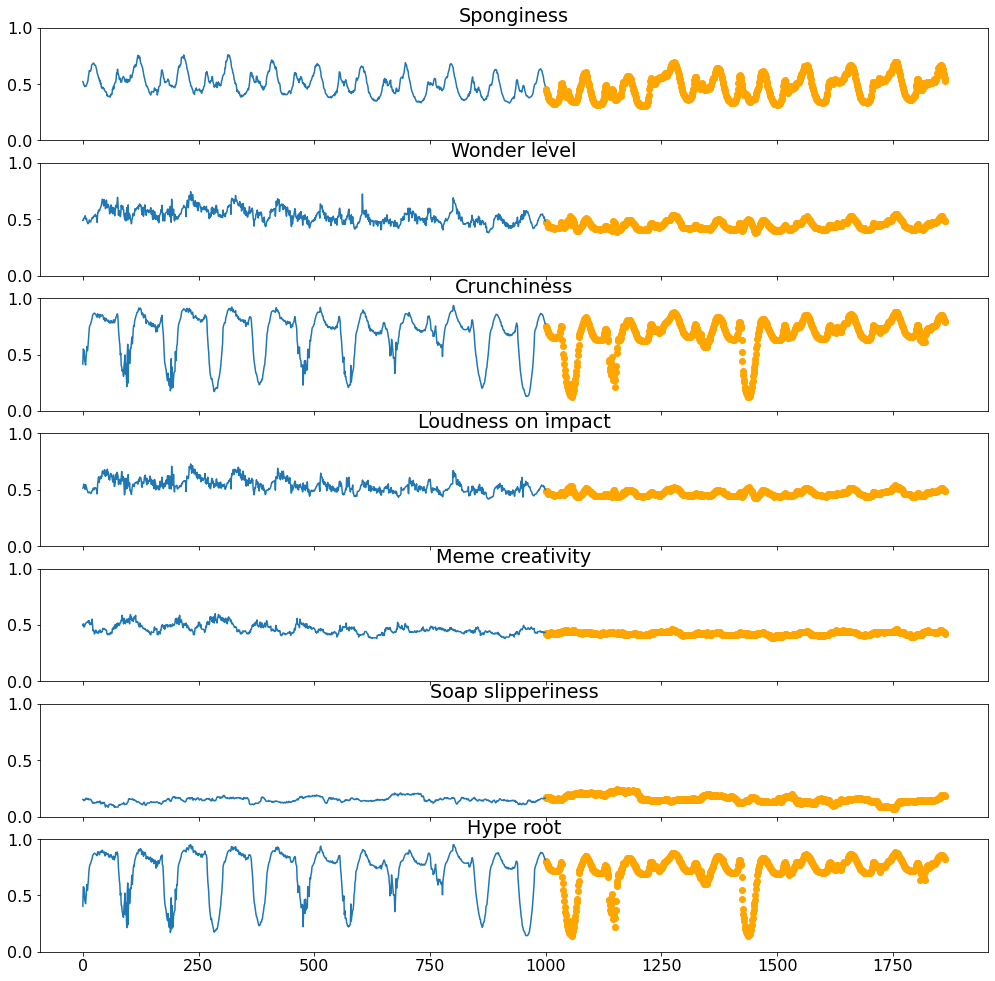

In [14]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [15]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [16]:
from typing import Tuple
from tensorflow.keras.regularizers import L1L2


class InnerConv1DBlock(tf.keras.layers.Layer):
    def __init__(self, filters: int, h: float, kernel_size: int, neg_slope: float = .01, dropout: float = .5, **kwargs):
        if filters <= 0 or h <= 0:
            raise ValueError('filters and h must be positive')
        super(InnerConv1DBlock, self).__init__(**kwargs)
        self.conv1d = tf.keras.layers.Conv1D(max(round(h * filters), 1), kernel_size, padding='same')
        self.leakyrelu = tf.keras.layers.LeakyReLU(neg_slope)

        self.dropout = tf.keras.layers.Dropout(dropout)

        self.conv1d2 = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')
        self.tanh = tf.keras.activations.tanh

    def call(self, input_tensor, training=None):
        x = self.conv1d(input_tensor)
        x = self.leakyrelu(x)

        if training:
            x = self.dropout(x)

        x = self.conv1d2(x)
        x = self.tanh(x)
        return x


class SciBlock(tfkl.Layer):
    def __init__(self, features: int, kernel_size: int, h: int, **kwargs):
        """
        :param features: number of features in the output
        :param kernel_size: kernel size of the convolutional layers
        :param h: scaling factor for convolutional module
        """

        super(SciBlock, self).__init__(**kwargs)
        self.features = features
        self.kernel_size = kernel_size
        self.h = h

    def build(self, input_shape):
        self.conv1ds = {k: InnerConv1DBlock(filters=self.features, h=self.h, kernel_size=self.kernel_size, name=k)
                        for k in ['psi', 'phi', 'eta', 'rho']}  # regularize?
        super().build(input_shape)
        # [layer.build(input_shape) for layer in self.conv1ds.values()]  # unneeded?

    def call(self, inputs, training=None):
        F_odd, F_even = inputs[:, ::2], inputs[:, 1::2]

        # Interactive learning as described in the paper
        F_s_odd = F_odd * tf.math.exp(self.conv1ds['phi'](F_even))
        F_s_even = F_even * tf.math.exp(self.conv1ds['psi'](F_odd))

        F_prime_odd = F_s_odd + self.conv1ds['rho'](F_s_even)
        F_prime_even = F_s_even - self.conv1ds['eta'](F_s_odd)

        return F_prime_odd, F_prime_even


class Interleave(tfkl.Layer):
    """A layer used to reverse the even-odd split operation."""

    def __init__(self, **kwargs):
        super(Interleave, self).__init__(**kwargs)

    def interleave(self, slices):
        if not slices:
            return slices
        elif len(slices) == 1:
            return slices[0]

        mid = len(slices) // 2
        even = self.interleave(slices[:mid])
        odd = self.interleave(slices[mid:])

        shape = tf.shape(even)
        return tf.reshape(tf.stack([even, odd], axis=3), (shape[0], shape[1] * 2, shape[2]))

    def call(self, inputs):
        return self.interleave(inputs)


class SciNet(tfkl.Layer):
    def __init__(self, horizon: int, features: int, levels: int, h: int, kernel_size: int,
                 regularizer: Tuple[float, float] = (0, 0), **kwargs):
        """
        :param horizon: number of time stamps in output
        :param features: number of features in output
        :param levels: height of the binary tree + 1
        :param h: scaling factor for convolutional module in each SciBlock
        :param kernel_size: kernel size of convolutional module in each SciBlock
        :param regularizer: activity regularization (not implemented)
        """

        if levels < 1:
            raise ValueError('Must have at least 1 level')
        super(SciNet, self).__init__(**kwargs)
        self.horizon = horizon
        self.features = features
        self.levels = levels
        self.interleave = Interleave()
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(
            horizon * features,
            kernel_regularizer=L1L2(0.001, 0.01),
            # activity_regularizer=L1L2(0.001, 0.01)
        )
        # self.regularizer = tf.keras.layers.ActivityRegularization(l1=regularizer[0], l2=regularizer[1])

        # tree of sciblocks
        self.sciblocks = [SciBlock(features=features, kernel_size=kernel_size, h=h)
                          for _ in range(2 ** levels - 1)]

    def build(self, input_shape):
        if input_shape[1] / 2 ** self.levels % 1 != 0:
            raise ValueError(f'timestamps {input_shape[1]} must be evenly divisible by a tree with '
                             f'{self.levels} levels')
        super().build(input_shape)
        # [layer.build(input_shape) for layer in self.sciblocks]  # input_shape

    def call(self, inputs, training=None):
        # cascade input down a binary tree of sci-blocks
        lvl_inputs = [inputs]  # inputs for current level of the tree
        for i in range(self.levels):
            i_end = 2 ** (i + 1) - 1
            i_start = i_end - 2 ** i
            lvl_outputs = [output for j, tensor in zip(range(i_start, i_end), lvl_inputs)
                           for output in self.sciblocks[j](tensor)]
            lvl_inputs = lvl_outputs

        x = self.interleave(lvl_outputs)
        x += inputs

        # not sure if this is the correct way of doing it. The paper merely said to use a fully connected layer to
        # produce an output. Can't use TimeDistributed wrapper. It would force the layer's timestamps to match that of
        # the input -- something SCINet is supposed to solve
        x = self.flatten(x)
        x = self.dense(x)
        x = tf.reshape(x, (-1, self.horizon, self.features))

        return x


class StackedSciNet(tf.keras.layers.Layer):
    def __init__(self, horizon: int, features: int, stacks: int, levels: int, h: int, kernel_size: int,
                 regularizer: Tuple[float, float] = (0, 0), **kwargs):
        """
        :param horizon: number of time stamps in output
        :param stacks: number of stacked SciNets
        :param levels: number of levels for each SciNet
        :param h: scaling factor for convolutional module in each SciBlock
        :param kernel_size: kernel size of convolutional module in each SciBlock
        :param regularizer: activity regularization (not implemented)
        """

        if stacks < 1:
            raise ValueError('Must have at least 1 stack')
        super(StackedSciNet, self).__init__(**kwargs)
        self.horizon = horizon
        self.scinets = [SciNet(horizon=horizon, features=features, levels=levels, h=h, kernel_size=kernel_size,
                               regularizer=regularizer) for _ in range(stacks)]
#         self.mse_fn = tf.keras.metrics.MeanSquaredError()
#         self.mae_fn = tf.keras.metrics.MeanAbsoluteError()

    # def build(self, input_shape):
    #     super().build(input_shape)
    #     [stack.build(input_shape) for stack in self.scinets]

    def call(self, inputs, targets=None, sample_weights=None, training=None):
        outputs = []
        for scinet in self.scinets:
            x = scinet(inputs)
            outputs.append(x)  # keep each stack's output for intermediate supervision
            inputs = tf.concat([x, inputs[:, x.shape[1]:, :]], axis=1)

        if targets is not None:
            # Calculate metrics
#             mse = self.mse_fn(targets, x, sample_weights)
#             mae = self.mae_fn(targets, x, sample_weights)
#             self.add_metric(mse, name='mean_squared_error')
#             self.add_metric(mae, name='mean_absolute_error')

            if training:
                # Calculate loss as sum of mean of norms of differences between output and input feature vectors for
                # each stack
                stacked_outputs = tf.stack(outputs)
                differences = stacked_outputs - targets
                loss = tf.linalg.normalize(differences, axis=1)[1]
                loss = tf.reshape(loss, (-1, self.horizon))
                loss = tf.reduce_sum(loss, 1)
                loss = loss / self.horizon
                loss = tf.reduce_sum(loss)
                self.add_loss(loss)

        return x

    def get_config(self):
        return super().get_config()

In [17]:
def build_StackedSciNet_model(p_input_shape, p_output_shape):
    input_train = tfkl.Input(shape=p_input_shape)
    output_train = tfkl.Input(shape=p_output_shape)

    predictions = StackedSciNet(horizon=telescope, features=p_input_shape[-1], stacks=2, levels=3, h=4,
                                kernel_size=5)(input_train)
    sciNet_model = tf.keras.Model(inputs=input_train, outputs=predictions)

    # Compile the model
    sciNet_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(),
                         metrics=[tf.keras.metrics.RootMeanSquaredError()])

    # Return the model
    return sciNet_model


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000, 7)]         0         
_________________________________________________________________
stacked_sci_net (StackedSciN (None, 864, 7)            84795816  
Total params: 84,795,816
Trainable params: 84,795,816
Non-trainable params: 0
_________________________________________________________________


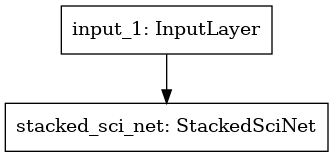

In [18]:
model = build_StackedSciNet_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [19]:
# Train the model
callbacks = create_folders_and_callbacks(model_name='StackedSciNet')

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=.1,
    callbacks=callbacks
).history

2021-12-28 12:34:57.754870: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
19/19 [==============================] - 48s 2s/step - loss: 1271.6418 - root_mean_squared_error: 16.3241 - val_loss: 982.6052 - val_root_mean_squared_error: 2.0713


2021-12-28 12:35:52.865014: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/200
19/19 [==============================] - 26s 1s/step - loss: 949.0382 - root_mean_squared_error: 2.4804 - val_loss: 900.8350 - val_root_mean_squared_error: 1.2432
Epoch 3/200
19/19 [==============================] - 26s 1s/step - loss: 858.8057 - root_mean_squared_error: 1.0844 - val_loss: 811.3530 - val_root_mean_squared_error: 0.8000
Epoch 4/200
19/19 [==============================] - 26s 1s/step - loss: 770.4496 - root_mean_squared_error: 0.7307 - val_loss: 725.0563 - val_root_mean_squared_error: 0.5034
Epoch 5/200
19/19 [==============================] - 26s 1s/step - loss: 686.5932 - root_mean_squared_error: 0.6038 - val_loss: 643.9326 - val_root_mean_squared_error: 0.4182
Epoch 6/200
19/19 [==============================] - 26s 1s/step - loss: 608.0279 - root_mean_squared_error: 0.5190 - val_loss: 568.4406 - val_root_mean_squared_error: 0.3764
Epoch 7/200
19/19 [==============================] - 26s 1s/step - loss: 535.3539 - root_mean_squared_error: 0.4527 - val_los

In [20]:
model.save('StackedSciNet')
# model = tfk.models.load_model('StackedSciNet')

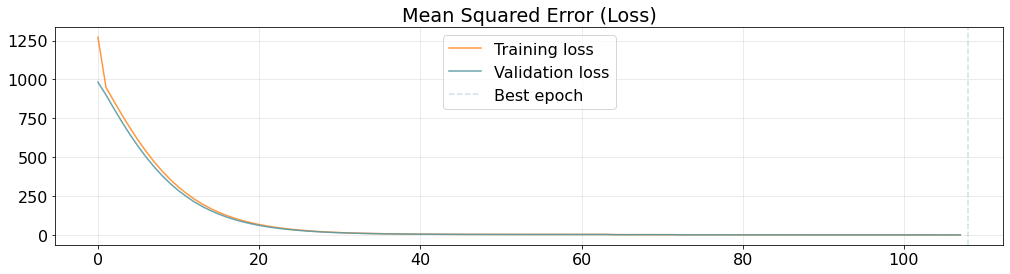

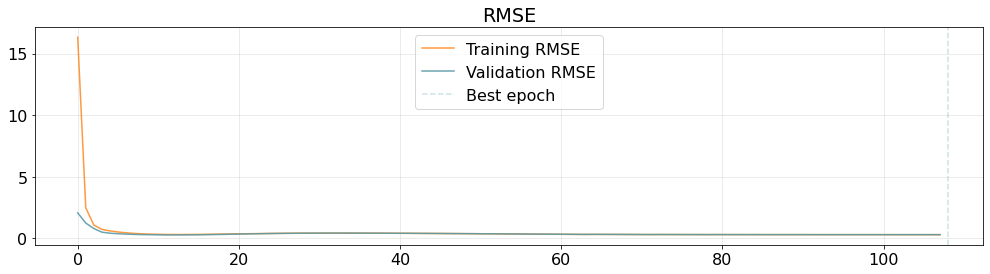

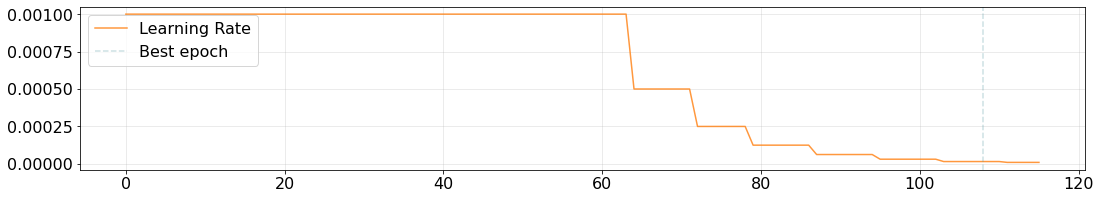

In [21]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17, 4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17, 4))
plt.plot(history['root_mean_squared_error'], label='Training RMSE', alpha=.8, color='#ff7f0e')
plt.plot(history['val_root_mean_squared_error'], label='Validation RMSE', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('RMSE')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18, 3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()